In [5]:

import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\redhu\OneDrive\Desktop\deep_research_workflow\deep_research


In [8]:
import sys, os
sys.path.append("C:/Users/redhu/OneDrive/Desktop/deep_research_workflow")

In [9]:
#import model loader
from deep_research.backend_server.utils.model_loader import ModelLoader

loader = ModelLoader()
llm = loader.load_llm()
llm.invoke("hii")

{"timestamp": "2025-11-02T03:19:30.333837Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-11-02T03:19:30.335930Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-11-02T03:19:30.337919Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-02T03:19:30.340236Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-11-02T03:19:30.341734Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-11-02T03:19:30.343619Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-02T03:19:30.349986Z", "level": "info", "event": "YAML config loaded"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-11-02T03:19:30.352022Z", "level": "info", "event": "Loading

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CXIut8Tjg9PR9b77IvVu90XdYaOZA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8967f3c1-6647-493f-995c-946952f97347-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [10]:
from typing import TypedDict, List
from pydantic import BaseModel,Field
from langgraph.graph import START,END,StateGraph
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [11]:

class Analyst(BaseModel):
    name: str = Field(description="name of analyst")
    role: str  = Field(description="role of analyst in the context of topic") 
    affiliation: str  = Field(description="primary affiliation of the analyst")
    description: str = Field(description="description of analyst, focus concern and motives")
    
    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Description: {self.description}\n"
        )
    

In [12]:
analyst = Analyst(
    name ='amit',
    role = "ML engineer",
    affiliation="AI research Lab",
    description="I am Ml engineer as well as Mechanical Engineer"
)

In [13]:
analyst.name

'amit'

In [14]:
analyst.role

'ML engineer'

In [15]:
print(analyst.persona)

Name: amit
Role: ML engineer
Affiliation: AI research Lab
Description: I am Ml engineer as well as Mechanical Engineer



In [16]:
class perspectives(BaseModel):
    analysts:List[Analyst] = Field(description="comprehensive list of analysts with their role and affiliations")
    
    

In [17]:
class GenerateAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

In [18]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [19]:
def create_analyst(state:GenerateAnalystState):
    "create analyst"
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    llm_with_structured_output = llm.with_structured_output(perspectives)
    
    system_message = analyst_instructions.format(
        topic = topic,
        max_analysts = max_analysts,
        human_analyst_feedback = human_analyst_feedback
    )
    analysts = llm_with_structured_output.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="generate a set of analysts")])
    
    return {"analysts":analysts.analysts}

    
                         

In [20]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Researcher', affiliation='World Health Organization', description='Dr. Emily Chen is a public health researcher with a focus on global health initiatives and disease prevention strategies. Her primary concern is understanding how health policies can be optimized to improve public health outcomes worldwide. She is motivated by the need to address health disparities and ensure equitable access to healthcare services.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard Medical School', description='Dr. Raj Patel is a healthcare technology analyst specializing in the integration of digital health solutions into traditional healthcare systems. His focus is on evaluating the impact of emerging technologies, such as telemedicine and AI, on patient care and healthcare delivery. He is driven by the potential of technology to transform healthcare accessibility and efficiency.')]}

In [21]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [22]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [23]:
from IPython.display import Image, display

In [24]:
builder =  StateGraph(GenerateAnalystState)

In [25]:
# add nodes
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

# add edges
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")

builder.add_conditional_edges(
    "human_feedback",
    should_continue,
    ["create_analyst", END]
)
                 

In [26]:
memory_saver = MemorySaver()

In [27]:
graph = builder.compile(interrupt_before=['human_feedback'],checkpointer=memory_saver)

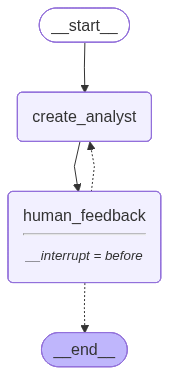

In [28]:
#display graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [29]:
topic = "the benefits of adopting Langgraph as an agent framework" 
max_analysts = 4
thread =  {"configurable":{"thread_id":1}}

In [30]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen is an expert in AI frameworks and their applications in various industries. Her focus is on evaluating the efficiency and scalability of agent frameworks like Langgraph. She is particularly interested in how Langgraph can streamline AI development processes and improve system integration.
--------------------------------------------------
Name: Raj Patel
Affiliation: Open Source Software Foundation
Role: Software Developer Advocate
Description: Raj is a passionate advocate for open-source software and its role in fostering innovation. He is interested in how Langgraph, as an open-source agent framework, can empower developers to create more robust and flexible AI solutions. His motive is to promote community-driven development and collaboration.
--------------------------------------------------
Name: Dr. Sarah Thompson
Affiliation: Global AI Ethics Consortium
Role: AI

In [32]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="langgraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [34]:
from langchain.utilities import WikipediaAPIWrapper
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run(query="agentic AI")
print(docs)

Page: Agentic AI
Summary: In artificial intelligence, agentic AI focuses on autonomous systems that can make decisions and perform tasks with limited or no human intervention. The independent systems automatically respond to conditions to produce process results. The field is closely linked to agentic automation, also known as agent-based process management systems, when applied to process automation. Applications include software development, customer support, cybersecurity and business intelligence. 



Page: AI browser
Summary: An AI browser is a web browser with integrated artificial intelligence (AI) capabilities, such as automatically summarizing webpage content or answering questions about it. A more dedicated type is agentic browser, based on the concept of agentic AI, which can even take actions (such as navigating webpages or filling out forms).
As of 2025, this is a recent development in the browser market, including new entrants from OpenAI, Opera and Perplexity. The design

In [38]:
from langchain.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os
load_dotenv(override=True)

api_key=os.getenv('tavily_api_key')



In [39]:
tavily = TavilySearchResults(api_key=api_key)
tavily.invoke("langgraph")

C:\Users\redhu\AppData\Local\Temp\ipykernel_8932\19665665.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(api_key=api_key)


[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': '# What is LangGraph?\n\nLast Updated : \n10 Oct, 2025\n\nSuggest changes\n\n1 Likes\n\nLangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions.',
  'score': 0.9345448},
 {'title': 'LangGraph - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/',
  'content': "Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we re

In [59]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[List,operator.add]
    analyst: Analyst
    interview: str
    sections: List 

class SearchQuery(BaseModel):
    search_query: str  = Field(None,description="search query for retrieval")

In [42]:

question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [43]:
print(analyst.persona)

Name: Michael O'Connor
Role: Enterprise Technology Strategist
Affiliation: Tech Innovations Inc.
Description: Michael advises large enterprises on technology adoption strategies. He is interested in how Langgraph can be integrated into existing enterprise systems to enhance operational efficiency and drive innovation. His focus is on the practical benefits and ROI of adopting new AI frameworks in business environments.



In [47]:
#function to generate questions
def generate_question(state: InterviewState):
    "node to generate question"
    analyst = state['analyst']
    message = state['messages']
    
    #generate questions
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + message)
    
    return {"message": [question]}
    

In [48]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [49]:
result  = generate_question(state)
result

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'message': [AIMessage(content="Hello Michael, my name is Sarah Thompson, and I'm an analyst interested in understanding how enterprises can effectively integrate new technologies to enhance their operations. I understand you're an expert in advising large enterprises on technology adoption strategies, particularly with a focus on AI frameworks like Langgraph. Could you share some specific examples of how Langgraph has been integrated into existing enterprise systems to drive innovation and improve operational efficiency?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 241, 'total_tokens': 319, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CXJlI8HClQPWdNc9lvYc785YTLOnM', 's

In [53]:
result['message'][0].content

"Hello Michael, my name is Sarah Thompson, and I'm an analyst interested in understanding how enterprises can effectively integrate new technologies to enhance their operations. I understand you're an expert in advising large enterprises on technology adoption strategies, particularly with a focus on AI frameworks like Langgraph. Could you share some specific examples of how Langgraph has been integrated into existing enterprise systems to drive innovation and improve operational efficiency?"

In [54]:
from langchain_core.messages import get_buffer_string

In [55]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [60]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [61]:

state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [62]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [66]:
print(result['context'][0])

<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>
In fact, the rapid adoption of AI agents by companies indicates a strategic shift. Early movers are using AI agents to handle tasks that were once bottlenecks, gaining an edge in customer responsiveness, data analysis, and innovation capacity. Using a framework like LangGraph ensures these AI initiatives are scalable and maintainable, so one is building a long-term strategic asset, not just a demo or one-off script.

### Practical Gains: Save Time and Money While Reducing Errors [...] Another advantage of the LangGraph approach is that one can precisely control when and how agents interact. The graph’s edges and nodes act like a playbook for the team of agents. One can have phases in the workflow where agents work in parallel, and then points where the workflow pauses and awaits a decision or input. [...] This approach has strong parallels to how human teams work, and indeed some benefits are the same: specializ

In [67]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [68]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [69]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework benefits for business innovation and digital transformation'


In [70]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [71]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

In [86]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "generate_question"

In [87]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [88]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [89]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

In [90]:
interview_builder = StateGraph(InterviewState)

In [91]:
# add nodes
interview_builder.add_node("generate_question",generate_question)
interview_builder.add_node('search_web',search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node('save_interview',save_interview)
interview_builder.add_node('write_section',write_section)

In [ ]:
#add edges
interview_builder.add_edge(START,"generate_question")
interview_builder.add_edge('generate_question','search_web')
interview_builder.add_edge('generate_question','search_wikipedia')
interview_builder.add_edge('search_web','generate_answer')
interview_builder.add_edge('search_wikipedia','generate_answer')
interview_builder.add_conditional_edges('generate_answer',route_messages,
                                        ['generate_question',
                                        'save_interview'])
interview_builder.add_edge('save_interview','write_section')
interview_builder.add_edge('write_section',END)


In [93]:
interview_graph = interview_builder.compile(checkpointer=memory_saver).with_config(run_name = "Conduct Interview")

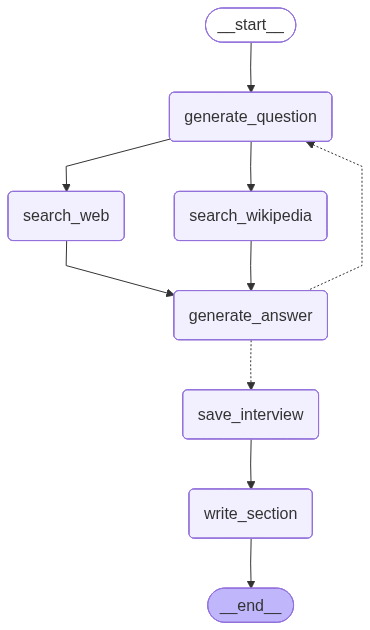

In [94]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [95]:
thread = {"configurable": {"thread_id": "1"}}

In [96]:
from IPython.display import Markdown

In [99]:
messages = [HumanMessage("So you said you were writing an article on langchain?")]

In [ ]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

In [103]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [104]:
from langgraph.types import Send

In [105]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]

In [106]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [107]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [108]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [109]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [110]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [111]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [112]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [113]:

graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory_saver)

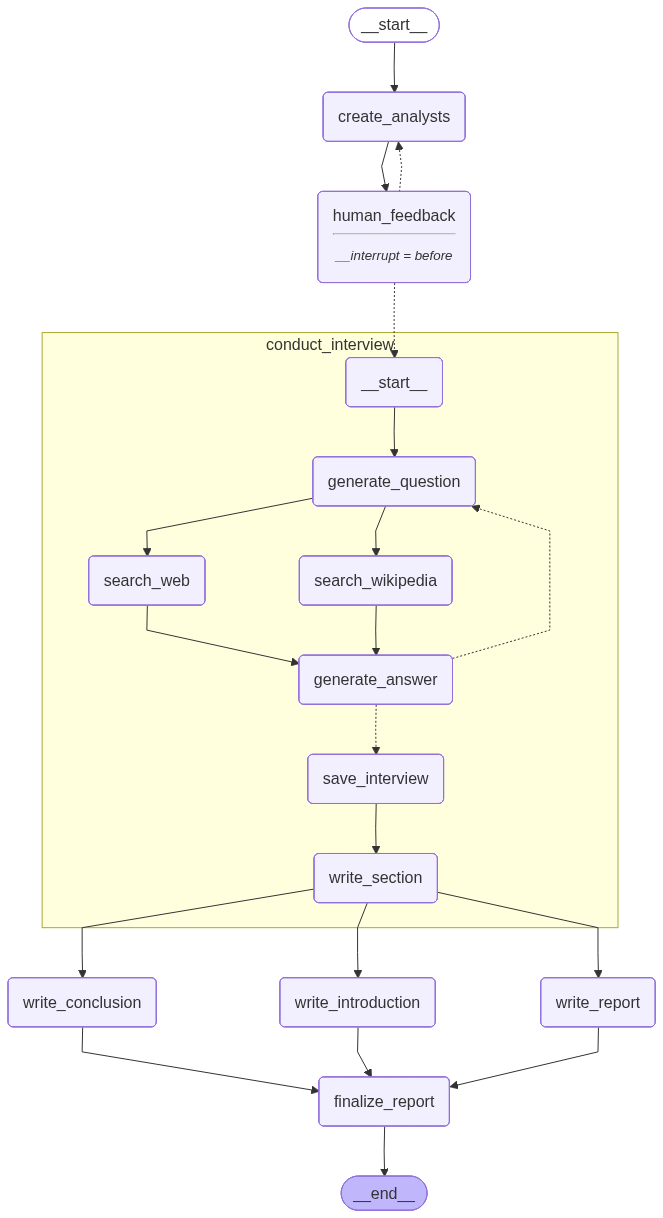

In [114]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [115]:
max_analysts = 3
topic = "How can generative help us to play the cricket?"
topic = "How can generative AI accelerate drug discovery?"
thread = {"configurable": {"thread_id": "1"}}

In [116]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen is an expert in AI frameworks and their applications in various industries. Her focus is on evaluating the efficiency and scalability of agent frameworks like Langgraph. She is particularly interested in how Langgraph can streamline AI development processes and improve system integration.
--------------------------------------------------
Name: Raj Patel
Affiliation: Open Source Software Foundation
Role: Software Developer Advocate
Description: Raj is a passionate advocate for open-source software and its role in fostering innovation. He is interested in how Langgraph, as an open-source agent framework, can empower developers to create more robust and flexible AI solutions. His motive is to promote community-driven development and collaboration.
--------------------------------------------------
Name: Dr. Sarah Thompson
Affiliation: Global AI Ethics Consortium
Role: AI

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: DeepMind
Role: AI Research Scientist
Description: Dr. Emily Chen is an AI research scientist at DeepMind, focusing on the application of machine learning and generative models in healthcare. Her primary interest lies in how generative AI can be used to simulate complex biological processes, thereby accelerating the drug discovery process. She is motivated by the potential of AI to reduce the time and cost associated with bringing new drugs to market.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Pfizer
Role: Pharmaceutical Industry Expert
Description: Dr. Raj Patel is a seasoned expert in the pharmaceutical industry with over 20 years of experience in drug development. He is particularly interested in how generative AI can enhance the efficiency of drug discovery pipelines by predicting molecular interactions and optimizing compound synthesis. His focus is on integrating AI technologies into existing workflows to i

In [117]:
graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7af2-ca4f-692b-8018-5cde10ac1671'}}

In [118]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: DeepMind
Role: AI Research Scientist
Description: Dr. Emily Chen is an AI research scientist at DeepMind, focusing on the application of machine learning and generative models in healthcare. Her primary interest lies in how generative AI can be used to simulate complex biological processes, thereby accelerating the drug discovery process. She is motivated by the potential of AI to reduce the time and cost associated with bringing new drugs to market.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Pfizer
Role: Pharmaceutical Industry Expert
Description: Dr. Raj Patel is a seasoned expert in the pharmaceutical industry with over 20 years of experience in drug development. He is particularly interested in how generative AI can enhance the efficiency of drug discovery pipelines by predicting molecular interactions and optimizing compound synthesis. His focus is on integrating AI technologies into existing workflows to i

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Aisha Kapoor
Affiliation: Institute of Computational Medicine
Role: AI and Drug Discovery Specialist
Description: Dr. Aisha Kapoor is a leading researcher in the application of AI technologies in drug discovery. Her focus is on how generative AI can be used to model complex biological systems and predict drug interactions, thereby accelerating the drug development process. She is motivated by the potential of AI to reduce the time and cost associated with bringing new drugs to market.
--------------------------------------------------
Name: Rajesh Mehta
Affiliation: Indian Institute of Technology
Role: AI Policy Analyst
Description: Rajesh Mehta is an AI policy analyst with a keen interest in the implications of AI technologies on the pharmaceutical industry. He explores the regulatory and ethical challenges posed by the use of generative AI in drug discovery, particularly in the context of the Indian pharmaceutical sector. His work aims to ensure that AI advancements are ali

In [119]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7af4-3929-6ea9-801c-2c9950886514'}}

In [120]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [121]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='how generative AI accelerates drug discovery'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='How generative AI accelerates drug discovery'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='how generative AI accelerates drug discovery'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='how generative AI accelerates drug discovery'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 0.466006 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 0.954712 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


ReadTimeout: HTTPConnectionPool(host='en.wikipedia.org', port=80): Read timed out. (read timeout=None)

In [122]:

from IPython.display import Markdown

In [123]:

final_state = graph.get_state(thread)

In [124]:
report = final_state.values.get('final_report')

In [125]:
Markdown(report)

<IPython.core.display.Markdown object>